In [142]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import itertools

RMSE: 4.83
R² Score: 0.73
          Feature  Coefficient
3   windspeedmean     6.223594
1       Tempmin_C    -2.233962
0       Tempmax_C     1.928870
7        humidity    -1.809670
4  solarradiation     1.732282
5         uvindex    -1.373584
2    windspeedmax     1.072046
6      cloudcover    -0.839232
8          precip     0.467326


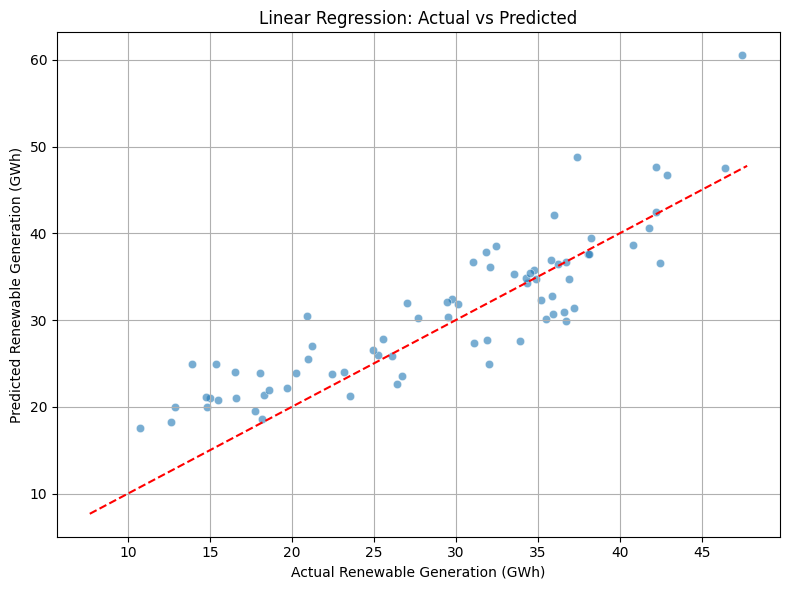

In [146]:
# Load dataset
df = pd.read_excel("./datasets/datasets.xlsx", sheet_name="Sheet1")

# Define features and target
features = [
    'Tempmax_C', 'Tempmin_C', 'windspeedmax', 'windspeedmean',
    'solarradiation', 'uvindex', 'cloudcover', 'humidity', 'precip'
]
target = '(Combined) Renewable_Generation_GWh'

X = df[features]
y = df[target]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Display feature coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coefficients)

# Visualize actual vs predicted values
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel('Actual Renewable Generation (GWh)')
plt.ylabel('Predicted Renewable Generation (GWh)')
plt.title('Linear Regression: Actual vs Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()


RMSE: 4.058
R² Score: 0.808


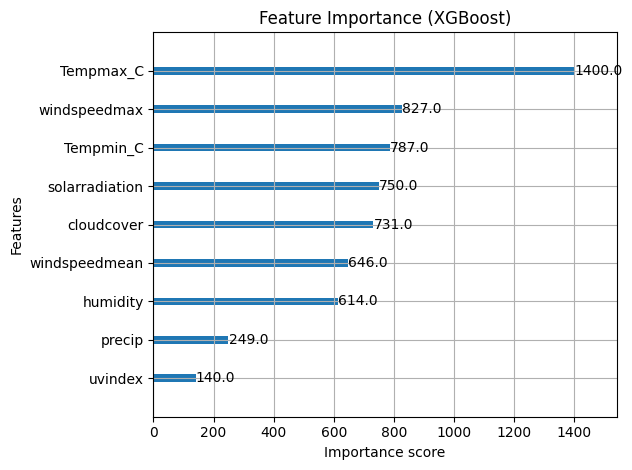

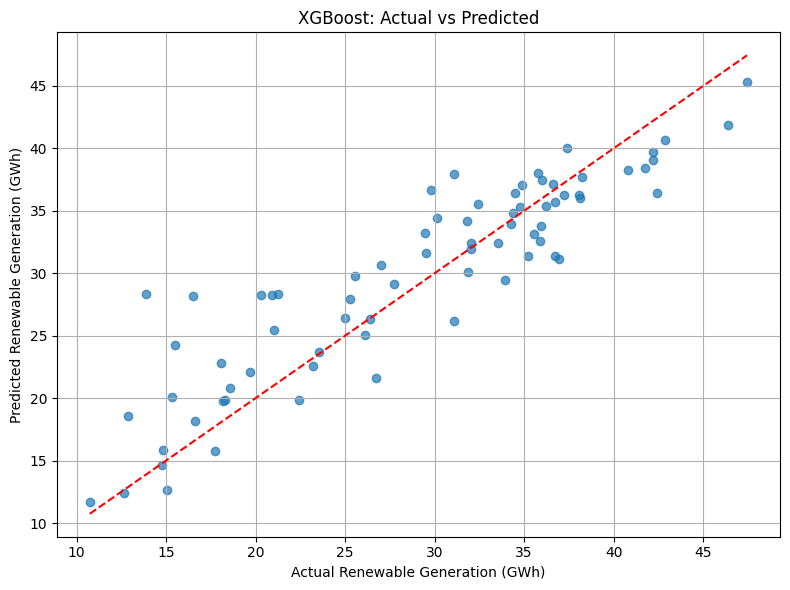

In [141]:
# Select features and target variable
features = [
    'Tempmax_C', 'Tempmin_C', 'windspeedmax', 'windspeedmean',
    'solarradiation', 'uvindex', 'cloudcover', 'humidity', 'precip'
]
X = df[features]
y = df['(Combined) Solar_GWh'] + df['Wind_GWh']  # total renewable generation

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=200,
    eta=0.05,
    max_depth=6,
    random_state=42,
    gamma=0,
    max_delta_step=0,
    alpha=0,
    colsample_bytree=1.0,
    subsample=0.6
)

model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# Plot feature importance
xgb.plot_importance(model)
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Renewable Generation (GWh)')
plt.ylabel('Predicted Renewable Generation (GWh)')
plt.title('XGBoost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


In [133]:
# Define features and target
features = [
    'Tempmax_C', 'Tempmin_C', 'windspeedmax', 'windspeedmean',
    'solarradiation', 'uvindex', 'cloudcover', 'humidity', 'precip'
]
X = df[features]
y = df['(Combined) Solar_GWh'] + df['Wind_GWh']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Extended parameter grid (around 2400 combinations)
param_grid = {
    'eta': [0.01, 0.02, 0.03, 0.04, 0.05],
    'max_depth': [3, 4, 5, 6],
    'gamma': [0, 2, 5, 7, 10],
    'max_delta_step': [0, 5, 10],
    'alpha': [0, 0.2, 0.4, 0.6, 0.8],
    'colsample_bytree': [0.8, 0.9, 0.96, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9]
}

# Generate all parameter combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"🔍 Total parameter combinations to test: {len(combinations)}")

# Search for the best parameter combination
results = []
best_rmse = float('inf')
best_params = None
best_r2 = None

for idx, params in enumerate(combinations):
    model = xgb.XGBRegressor(
        n_estimators=200,
        random_state=42,
        verbosity=0,
        **params,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Index': idx + 1,
        'RMSE': rmse,
        'R2': r2,
        **params
    })

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        best_r2 = r2

    if (idx + 1) % 100 == 0:
        print(f"[{idx+1}/{len(combinations)}] RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Output the best result
print("\nBest Parameters:")
print(best_params)
print(f"Best RMSE: {best_rmse:.2f}")

# Save results to DataFrame (for visualization or export)
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_grid_search_results.csv", index=False)


🔍 Total parameter combinations to test: 24000
[100/24000] RMSE: 28.60, R²: 0.67
[200/24000] RMSE: 23.61, R²: 0.73
[300/24000] RMSE: 23.10, R²: 0.73
[400/24000] RMSE: 27.94, R²: 0.67
[500/24000] RMSE: 23.16, R²: 0.73
[600/24000] RMSE: 28.01, R²: 0.67
[700/24000] RMSE: 23.60, R²: 0.73
[800/24000] RMSE: 22.90, R²: 0.73
[900/24000] RMSE: 23.55, R²: 0.73
[1000/24000] RMSE: 23.12, R²: 0.73
[1100/24000] RMSE: 28.05, R²: 0.67
[1200/24000] RMSE: 23.64, R²: 0.72
[1300/24000] RMSE: 28.35, R²: 0.67
[1400/24000] RMSE: 23.02, R²: 0.73
[1500/24000] RMSE: 22.41, R²: 0.74
[1600/24000] RMSE: 27.39, R²: 0.68
[1700/24000] RMSE: 22.55, R²: 0.74
[1800/24000] RMSE: 27.51, R²: 0.68
[1900/24000] RMSE: 22.85, R²: 0.73
[2000/24000] RMSE: 22.22, R²: 0.74
[2100/24000] RMSE: 22.97, R²: 0.73
[2200/24000] RMSE: 22.22, R²: 0.74
[2300/24000] RMSE: 27.55, R²: 0.68
[2400/24000] RMSE: 22.31, R²: 0.74
[2500/24000] RMSE: 28.45, R²: 0.67
[2600/24000] RMSE: 22.83, R²: 0.73
[2700/24000] RMSE: 22.93, R²: 0.73
[2800/24000] RMSE:

RMSE: 4.36
R² Score: 0.78


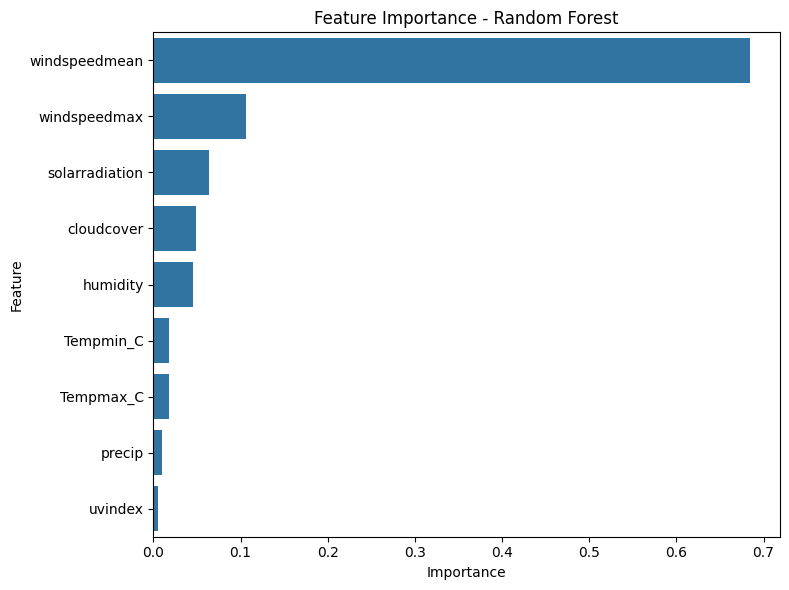

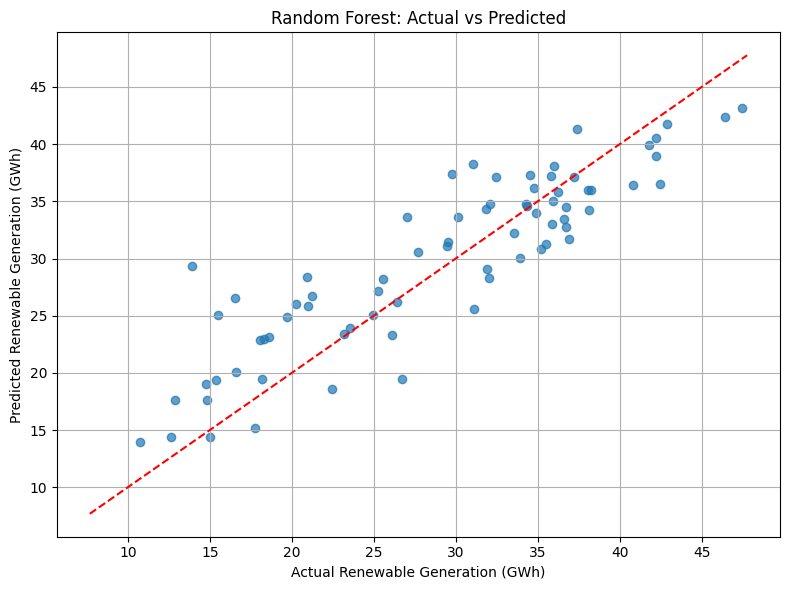

In [145]:
features = [
    'Tempmax_C','Tempmin_C','windspeedmax','windspeedmean',
    'solarradiation','uvindex','cloudcover','humidity','precip'
]
X = df[features]
y = df['(Combined) Renewable_Generation_GWh']

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=26,        # Number of trees
    max_depth=11,           # Maximum depth of each tree
    random_state=42,
    n_jobs=-1,              # Parallel computation
    min_samples_leaf=5,
    bootstrap=True
)
rf_model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.2f}')

# Visualize feature importance
importances = rf_model.feature_importances_
feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

# Visualize actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Actual Renewable Generation (GWh)')
plt.ylabel('Predicted Renewable Generation (GWh)')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


In [144]:
for i in range (1,11):
    print(i)
    rf_model = RandomForestRegressor(
        n_estimators=26,       
        max_depth=11,           
        random_state=42,
        n_jobs=-1,               
        min_samples_leaf=i
    )
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f'RMSE: {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')

1
RMSE: 4.38
R² Score: 0.78
2
RMSE: 4.37
R² Score: 0.78
3
RMSE: 4.50
R² Score: 0.76
4
RMSE: 4.47
R² Score: 0.77
5
RMSE: 4.36
R² Score: 0.78
6
RMSE: 4.36
R² Score: 0.78
7
RMSE: 4.36
R² Score: 0.78
8
RMSE: 4.36
R² Score: 0.78
9
RMSE: 4.40
R² Score: 0.77
10
RMSE: 4.52
R² Score: 0.76
